In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ,  assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
print("Available backends:")
provider.backends()


Available backends:


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [4]:
backend = provider.get_backend('ibmq_lima')

In [5]:
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
#def initialization in superposition
def initialization(qc, qubits):
    for qubit in qubits:
        qc.h(qubit)
    return qc

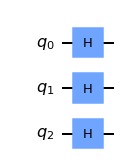

In [9]:
example = QuantumCircuit(3)
example_ = initialization(example, range(3))
f = example_.draw('mpl')
f.savefig('Images/QiskitGInit.png')
f

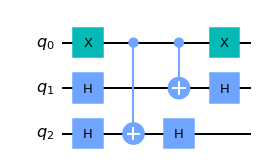

In [44]:
#def oracle marking state [0,0,.....1]
# 1 state marked
num_q = 3

from numpy import pi
qc = QuantumCircuit(num_q)

for i in range(num_q -2):
    qc.x(i)
qc.h(num_q -1)
qc.mct(list(range(num_q -2)), num_q -1)  # multi-controlled-toffoli
qc.h(num_q -2)
#o = [0, 1, 2, 4]
qc.mct(list(range(num_q -2)), num_q -2)
#qc.mct(o, num_q -2)
qc.h(num_q -2)
#temp
#qc.h(num_q -2)
#qc.mct(list(range(num_q -2)), num_q -2)  # multi-controlled-toffoli
#qc.h(num_q -2)
#fine temp

qc.h(num_q -1)
for i in range(num_q -2):
    qc.x(i)

oracle_ = qc.to_gate()
oracle_.name = "Oracle"
f = qc.draw('mpl')
f.savefig('Images/QiskitGOracle.png')
f

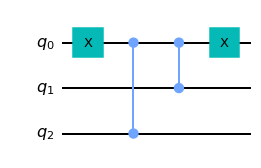

In [53]:
num_q = 3

from numpy import pi
qc = QuantumCircuit(num_q)

qc.x(0)
qc.cz(0, 2)
qc.cz(0, 1)
qc.x(0)
oracle_ = qc.to_gate()
oracle_.name = "Oracle"
f = qc.draw('mpl')
#f.savefig('Images/QiskitGOracle.png')
f

In [54]:
#diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diff"
    return U_s

In [46]:
a = diffuser(num_qubits)
f = a.draw()
f.savefig('Images/QiskitGDiffuser.png')
f

Traceback (most recent call last):
  File "<ipython-input-46-5b5d3cf5e42c>", line 2, in <module>
    f = a.draw()
AttributeError: 'Gate' object has no attribute 'draw'

Use %tb to get the full traceback.


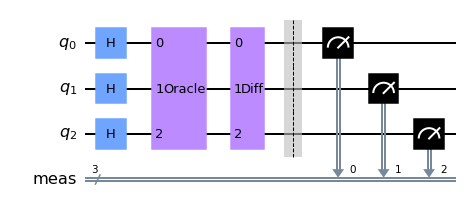

In [55]:
num_qubits = 3
grover_circ = QuantumCircuit(num_qubits)
grover_circ = initialization(grover_circ, range(num_qubits))
for i in range(1):
    grover_circ.append(oracle_, range(num_qubits))
    grover_circ.append(diffuser(num_qubits), range(num_qubits))
grover_circ.measure_all()
f = grover_circ.draw()
#f.savefig('Images/QiskitGAll.png')
f

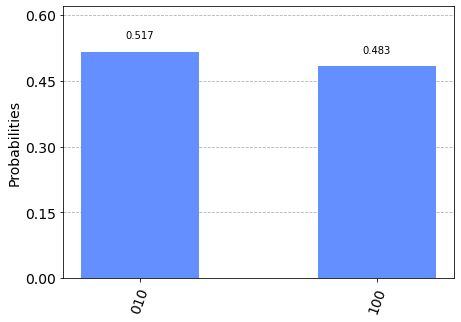

In [56]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circ, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
f = plot_histogram(counts)
#f.savefig('Images/QiskitGSimulator.png')
f

In [29]:
from qiskit.tools.monitor import job_monitor
device = backend
transpiled_grover_circuit = transpile(grover_circ, device, optimization_level=3)
job = device.run(transpiled_grover_circuit, shots = 8000)
job_monitor(job, interval=2)

Job Status: job has successfully run


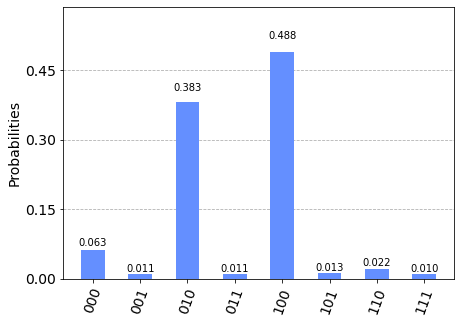

In [30]:
results = job.result()
answer = results.get_counts(grover_circ)
f = plot_histogram(answer)
f.savefig('Images/QiskitGIBMQlima.png')
f